In [1]:
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
from tqdm import tqdm
import logging
import seaborn as sn

from rsna_dataloader import *


In [2]:
class CustomResNet(nn.Module):
    def __init__(self, out_features=512, pretrained_weights=None):
        super(CustomResNet, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        if pretrained_weights:
            self.model.load_state_dict(torch.load(pretrained_weights))
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features=num_ftrs, out_features=out_features)

    def forward(self, x):
        return self.model(x)


class CustomLSTM(nn.Module):
    hidden_size = 256
    num_layers = 2

    def __init__(self, num_classes=5 * 2, drop_rate=0.2, resnet_weights=None):
        super(CustomLSTM, self).__init__()
        self.cnn = CustomResNet(pretrained_weights=resnet_weights)
        self.lstm = nn.LSTM(input_size=512, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, bidirectional=True)
        self.head = nn.Sequential(
            nn.Linear(256, 128),
            # nn.BatchNorm1d(256),
            nn.Dropout(drop_rate),
            nn.LeakyReLU(0.1),
            nn.Linear(128, num_classes),
        )
    def forward(self, x_3d):
        hidden = None

        # Iterate over each frame of a video in a video of batch * frames * channels * height * width
        for t in range(x_3d.size(1)):
            x = self.cnn(x_3d[:, t])
            # Pass latent representation of frame through lstm and update hidden state
            out, hidden = self.lstm(x.unsqueeze(0), hidden)

            # Get the last hidden state (hidden is a tuple with both hidden and cell state in it)
        x = self.head(hidden[0][-1])

        return x


In [3]:
model = torch.load("../models/resnet18_lstm_t2stir.pt")

In [4]:
transform_val = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),  # Convert back to uint8 for PIL
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

In [5]:
data_basepath = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
training_data = retrieve_training_data(data_basepath)

In [6]:
test_loader = create_series_level_test_datasets_and_loaders(training_data, "Sagittal T2/STIR", transform_val, data_basepath + "train_images")

In [7]:
label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}
def get_output_class(val):
    if val <= 0.33:
        return 0
    elif val <= 0.66:
        return 1
    else:
        return 2

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomLSTM(
  (cnn): CustomResNet(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNo

In [9]:
preds = []
for image, label in tqdm(test_loader):
    image = image.to(device)
    preds.append((model(image).detach().cpu().numpy(), label.numpy()))
    if len(preds) == 100:
        break

  5%|▌         | 99/1973 [00:32<10:17,  3.03it/s]


In [10]:
preds

[(array([[ 339.5266  ,  -17.447647, -242.89268 , -121.977844, -378.95523 ,
           418.89304 , -381.93716 , -493.7193  , -531.88324 ,  -34.887356]],
        dtype=float32),
  array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])),
 (array([[ 339.5266  ,  -17.447647, -242.89268 , -121.977844, -378.95523 ,
           418.89304 , -381.93716 , -493.7193  , -531.88324 ,  -34.887356]],
        dtype=float32),
  array([[0, 0, 0, 0, 1, 0, 1, 1, 0, 0]])),
 (array([[ 339.5266  ,  -17.447647, -242.89268 , -121.977844, -378.95523 ,
           418.89304 , -381.93716 , -493.7193  , -531.88324 ,  -34.887356]],
        dtype=float32),
  array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])),
 (array([[ 339.5266  ,  -17.447647, -242.89268 , -121.977844, -378.95523 ,
           418.89304 , -381.93716 , -493.7193  , -531.88324 ,  -34.887356]],
        dtype=float32),
  array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])),
 (array([[ 339.5266  ,  -17.447647, -242.89268 , -121.977844, -378.95523 ,
           418.89304 , -381.93716 , -493.7193

In [11]:
def scores_to_classes(arr):
    ret = []
    for i in range(0, len(arr)-1, 2):
        if arr[i] == 0:
            ret.append(0)
        elif arr[i] == 1:
            ret.append(2)
        else:
            ret.append(1)
            
    return ret

In [12]:
pred_classes = [(scores_to_classes(e[0][0]), scores_to_classes(e[1][0])) for e in preds]

In [13]:
pred_classes_0 = [e[0][4] for e in pred_classes]
pred_classes_0_ = [e[1][4] for e in pred_classes]

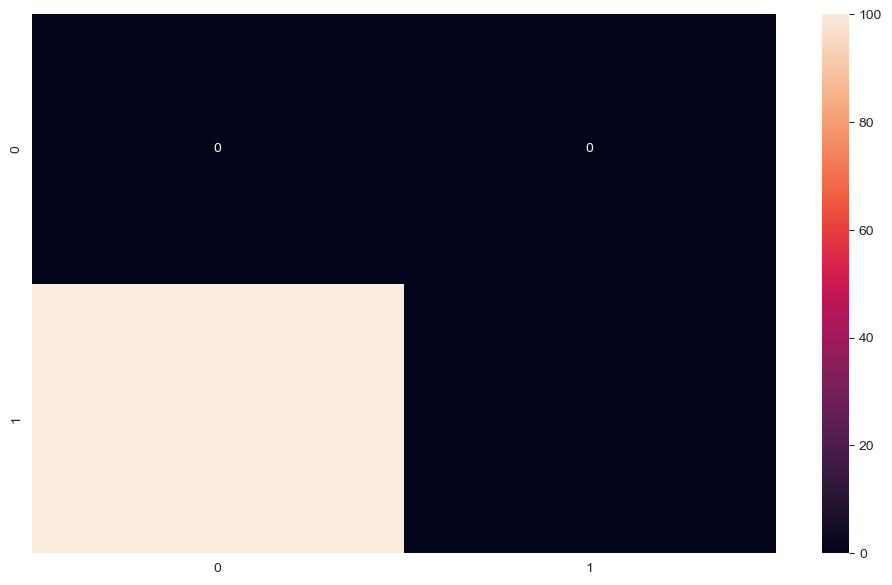

In [14]:
cf_matrix = confusion_matrix(pred_classes_0, pred_classes_0_)
df_cm = pd.DataFrame(cf_matrix)
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True)
plt.show()


In [15]:
training_data

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,../data/rsna-2024-lumbar-spine-degenerative-cl...
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,../data/rsna-2024-lumbar-spine-degenerative-cl...
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,../data/rsna-2024-lumbar-spine-degenerative-cl...
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,../data/rsna-2024-lumbar-spine-degenerative-cl...
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,../data/rsna-2024-lumbar-spine-degenerative-cl...
...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,Right Subarticular Stenosis,L1/L2,normal_mild,3390218084,2,307.180844,354.869960,Axial T2,4290709089_right_subarticular_stenosis_l1_l2,../data/rsna-2024-lumbar-spine-degenerative-cl...
48688,4290709089,Right Subarticular Stenosis,L2/L3,normal_mild,3390218084,6,301.440933,362.044847,Axial T2,4290709089_right_subarticular_stenosis_l2_l3,../data/rsna-2024-lumbar-spine-degenerative-cl...
48689,4290709089,Right Subarticular Stenosis,L3/L4,normal_mild,3390218084,10,302.875911,356.304937,Axial T2,4290709089_right_subarticular_stenosis_l3_l4,../data/rsna-2024-lumbar-spine-degenerative-cl...
48690,4290709089,Right Subarticular Stenosis,L4/L5,normal_mild,3390218084,15,305.745866,340.520184,Axial T2,4290709089_right_subarticular_stenosis_l4_l5,../data/rsna-2024-lumbar-spine-degenerative-cl...


In [16]:
training_data[training_data["condition"] == "Spinal Canal Stenosis"].groupby(["severity"]).count()

,study_id,condition,level,series_id,instance_number,x,y,series_description,row_id,image_path
severity,,,,,,,,,,
moderate,732,732,732,732,732,732,732,732,732,732
normal_mild,8552,8552,8552,8552,8552,8552,8552,8552,8552,8552
severe,469,469,469,469,469,469,469,469,469,469


In [8]:
pretrained_coord_path = "C:\\Users\Victor\\Documents\\python-doodles\\models\\resnet18_cnn_coordinates_t2stir\\resnet18_cnn_coordinates_t2stir_20.pt"

In [9]:
import torch.nn as nn
from transformers import AutoModelForImageClassification

class CoordinateDetector2D(nn.Module):
    def __init__(self, out_features=10, pretrained_weights=None):
        super(CoordinateDetector2D, self).__init__()
        self.model = AutoModelForImageClassification.from_pretrained("BehradG/resnet-18-MRI-Brain", torchscript=True)
        if pretrained_weights:
            self.model.load_state_dict(torch.load(pretrained_weights))
        self.model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=out_features),
        )

    def forward(self, x):
        return self.model(x)[0]


In [10]:
import torch

coordinate_model = torch.load(pretrained_coord_path)

In [11]:
%load_ext autoreload
%autoreload 2

from rsna_dataloader import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from torchvision import transforms
from torchvision.transforms import v2

data_basepath = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
training_data = retrieve_training_data(data_basepath)

transform_train = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),  # Convert back to uint8 for PIL
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.3),
    # transforms.RandomVerticalFlip(p=0.3),
    # transforms.RandomRotation([-30, 30]),
    transforms.RandomChoice([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.2)),
        v2.Identity(),
    ], p=[0.25, 0.75]),
    # v2.RandomPhotometricDistort(p=0.2),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),  # Convert back to uint8 for PIL
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

In [13]:
trainloader, valloader, trainset, valset = create_coordinate_datasets_and_loaders(training_data,
                                                                                                 "Sagittal T2/STIR",
                                                                                                 transform_val,
                                                                                                 # Try overfitting first
                                                                                                 transform_val,
                                                                                                 data_basepath + "train_images",
                                                                                                 num_workers=0,
                                                                                                 batch_size=1)


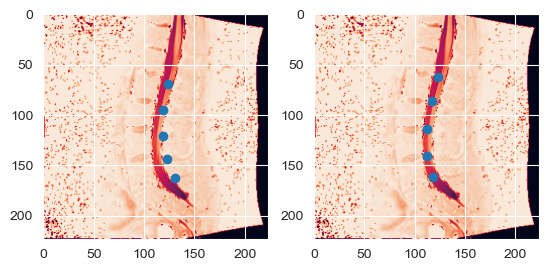

In [15]:
image, label = valset[15]
f, axarr = plt.subplots(1, 2)

inferred = coordinate_model(image.unsqueeze(0).to("cuda")).detach().cpu()[0]
x_ = [inferred[i] for i in range(0, len(inferred), 2)]
y_ = [inferred[i] for i in range(1, len(inferred), 2)]

axarr[0].scatter(x_, y_) 
axarr[0].imshow(image.squeeze(0)[0])

x = [label[i] for i in range(0, len(label), 2)]
y = [label[i] for i in range(1, len(label), 2)]

plt.scatter(x, y)
axarr[1].imshow(image.squeeze(0)[0])